In [1]:
# importing libraries
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [2]:
# device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
# define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5), (0.5))]) # normalize data; mean = 0.5, std = 0.5

# download and load training dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size = 32, shuffle=True)

# download and load testing dataset
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(dataset= test_dataset, batch_size = 32, shuffle=False)

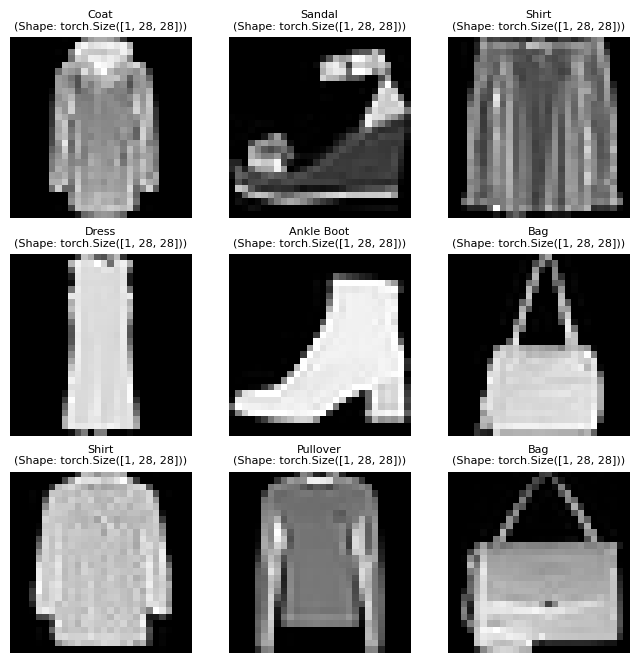

In [4]:
# assign labels
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = (3,3)

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()  
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.title(f"{labels_map[label]}\n(Shape: {img.shape})", fontdict={'fontsize':8})
    plt.imshow(img.squeeze(), cmap="gray")
    
plt.show()

In [5]:
# building the model
input_layer = 784  
hidden_layers = [256, 128]  
output_layer = 10  

model = nn.Sequential(
    nn.Linear(input_layer, hidden_layers[0]), 
    nn.ReLU(), 
    nn.Dropout(p=0.2), 
    nn.Linear(hidden_layers[0], hidden_layers[1]),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_layers[1], hidden_layers[2]), 
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(hidden_layers[2], output_layer),
    nn.LogSoftmax(dim=1)) #

print(model)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=128, out_features=10, bias=True)
  (7): LogSoftmax(dim=1)
)


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
num_epochs = 30 

training_losses = []
testing_losses = []

# training loop for each epoch
for epoch in range(1, num_epochs + 1):
    total_training_loss = 0
    n_correct = 0  
    n_samples = 0  

    for i, (images, labels) in enumerate(train_loader):
        images = images.view(images.shape[0], -1).reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward pass + optimization
        optimizer.zero_grad() # zero the gradient buffers
        loss.backward()
        optimizer.step()

        total_training_loss += loss.item()

    # test
    total_testing_loss = 0
    test_correct = 0
    with torch.no_grad(): # gradient computation disabled
        model.eval()
        for images, labels in test_loader:
            images = images.view(images.shape[0], -1).to(device) 
            logps = model(images)
            loss = criterion(logps, labels) # compares model's predictions to group truth labels
            
            total_testing_loss += loss.item()
            
            ps = torch.exp(model(images)) # calculate class probabilities 
            
            top_p, top_class = ps.topk(1, dim=1) # identifies top predicted class for each image
            
            equals = top_class == labels.view(*top_class.shape) # check if predicted class matches actual labels
            
            test_correct += torch.mean(equals.type(torch.FloatTensor)) # update accuracy based on correct predictions

        model.train() # dropout back on

    # calculate mean training and testing losses for this epoch
    training_losses.append(total_training_loss / len(train_loader))
    testing_losses.append(total_testing_loss / len(test_loader))

    # print the progress for the current epoch
    print(f"Epoch: {epoch}/{num_epochs}.. ",
          "Train Loss: {:3f}.. ".format(training_losses[-1]), 
          "Test Loss: {:3f}".format(testing_losses[-1]),
          "Test Accuracy: {:3f}".format(test_correct / len(test_loader)))

Epoch: 1/30..  Train Loss: 0.536570..  Test Loss: 0.432142 Test Accuracy: 0.843351
Epoch: 2/30..  Train Loss: 0.399989..  Test Loss: 0.384431 Test Accuracy: 0.861522
Epoch: 3/30..  Train Loss: 0.368359..  Test Loss: 0.361004 Test Accuracy: 0.868910
Epoch: 4/30..  Train Loss: 0.343894..  Test Loss: 0.357442 Test Accuracy: 0.869209
Epoch: 5/30..  Train Loss: 0.328237..  Test Loss: 0.353614 Test Accuracy: 0.871106
Epoch: 6/30..  Train Loss: 0.316758..  Test Loss: 0.344125 Test Accuracy: 0.874800
Epoch: 7/30..  Train Loss: 0.310239..  Test Loss: 0.338809 Test Accuracy: 0.877196
Epoch: 8/30..  Train Loss: 0.298189..  Test Loss: 0.337018 Test Accuracy: 0.883986
Epoch: 9/30..  Train Loss: 0.293539..  Test Loss: 0.326067 Test Accuracy: 0.880591
Epoch: 10/30..  Train Loss: 0.285993..  Test Loss: 0.330978 Test Accuracy: 0.880990
Epoch: 11/30..  Train Loss: 0.278011..  Test Loss: 0.331473 Test Accuracy: 0.878894
Epoch: 12/30..  Train Loss: 0.272576..  Test Loss: 0.333446 Test Accuracy: 0.879593
E

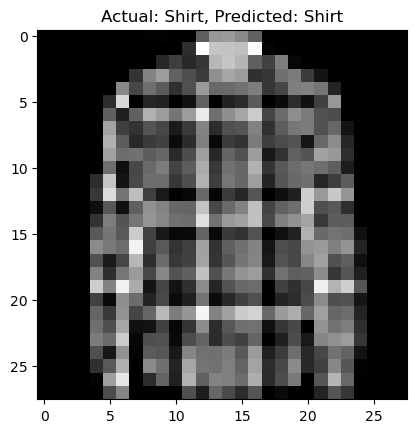

In [7]:
check = 7
with torch.no_grad():
    model.eval() 
    image, actual_label = test_dataset[check]
    image = image.view(1, -1).to(device)
    predicted_label = model(image).argmax().item()
    actual_clothing = test_dataset.classes[actual_label]
    predicted_clothing = test_dataset.classes[predicted_label]

# display image, clothing name, predicted clothing name
image = image.view(28, 28)
plt.imshow(image.cpu(), cmap='gray')
plt.title(f"Actual: {actual_clothing}, Predicted: {predicted_clothing}")
plt.show()